In [8]:
import json
import torch
from torch import nn
import torchvision
from stacker_net.train import MyDataset
import random
import numpy as np
from main import *
from PIL import Image
from metrics.foreground_metric3 import foreground_score
import pickle
from torch.utils.data import DataLoader, random_split
from outpainter_net.net import OutpainterNet
from outpainter_net.train import train
from tqdm import tqdm
import sys
from torchvision.transforms.functional import center_crop, resize
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(10,8)})

sys.path.insert(0, "/mnt/c/Users/proto/repos/image-outpainting")
import outpainting

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
selection_filename = 'data/selected_images.json'
with open(selection_filename, 'r') as f:
        paths = json.load(f)
transforms = torchvision.transforms.Compose([
    torchvision.transforms.PILToTensor(),
    torchvision.transforms.ConvertImageDtype(torch.float32)
])
img_ds = MyDataset('data/data_256', paths, transform=transforms)

1

In [3]:
back_to_pil = torchvision.transforms.ToPILImage()
images = [np.array(back_to_pil(img_ds[i])) for i in random.sample(range(len(img_ds)), 10)]
base_dims = np.array((256, 256))
dims = np.array([
    [256, 288],
    [256, 384],
    [288, 256],
    [256, 224],
    [256, 128],
    [224, 256],
    [288, 288],
    [224, 224]
])
save_dir = "data/experiments/1/"
predictor, coi = init_detectron()

In [10]:

for idx, img in tqdm(enumerate(images)):
    Image.fromarray(img).save(save_dir + str(idx) + "_og.png")
    for idx2, dim in enumerate(dims):
        mask = create_mask(predictor, coi, img)
        output1, mask1 = recompose(img, dim, mask, True)
        output2, mask2 = recompose(img, dim, mask)
        Image.fromarray(output1.astype(np.uint8)).save(save_dir + str(idx) + "_" + str(idx2) + "_base.png")
        Image.fromarray(output2.astype(np.uint8)).save(save_dir + str(idx) + "_" + str(idx2) + "_mine.png")

0it [00:00, ?it/s]/home/proto/miniconda3/envs/vision-stretcher/lib/python3.9/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/home/proto/miniconda3/envs/vision-stretcher/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180487213/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/proto/miniconda3/envs/vision-stretcher

2

In [4]:
sample = random.sample(range(len(img_ds)), 50)
images = [np.array(back_to_pil(img_ds[i])) for i in sample]
stats = {}

In [10]:
def measure_recomposition(images, target_size, predictor, coi):
    stats_unmasked = []
    stats_masked = []
    for idx, img in enumerate(tqdm(images)):
        mask = create_mask(predictor, coi, img)
        output1, mask1 = recompose(img, target_size, mask, True)
        output2, mask2 = recompose(img, target_size, mask)
        stats_unmasked.append(foreground_score(mask, mask1))
        stats_masked.append(foreground_score(mask, mask2))
    return {"unmasked": stats_unmasked, "masked": stats_masked}

In [8]:
stats[.5] = measure_recomposition(images, [256, 128], predictor, coi)

0it [00:00, ?it/s]/home/proto/miniconda3/envs/vision-stretcher/lib/python3.9/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
1it [00:27, 27.11s/it]/home/proto/miniconda3/envs/vision-stretcher/lib/python3.9/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc')

In [11]:
stats[.75] = measure_recomposition(images, [256, 192], predictor, coi)

  0%|          | 0/50 [00:00<?, ?it/s]/home/proto/miniconda3/envs/vision-stretcher/lib/python3.9/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
  2%|▏         | 1/50 [00:15<12:51, 15.74s/it]/home/proto/miniconda3/envs/vision-stretcher/lib/python3.9/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior

In [12]:
stats[.875] = measure_recomposition(images, [256, 224], predictor, coi)

  0%|          | 0/50 [00:00<?, ?it/s]/home/proto/miniconda3/envs/vision-stretcher/lib/python3.9/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
  2%|▏         | 1/50 [00:08<07:11,  8.82s/it]/home/proto/miniconda3/envs/vision-stretcher/lib/python3.9/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior

In [13]:
stats[1.125] = measure_recomposition(images, [256, 288], predictor, coi)

  0%|          | 0/50 [00:00<?, ?it/s]/home/proto/miniconda3/envs/vision-stretcher/lib/python3.9/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
  2%|▏         | 1/50 [00:09<08:05,  9.90s/it]/home/proto/miniconda3/envs/vision-stretcher/lib/python3.9/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior

In [14]:
stats[1.25] = measure_recomposition(images, [256, 320], predictor, coi)

  0%|          | 0/50 [00:00<?, ?it/s]/home/proto/miniconda3/envs/vision-stretcher/lib/python3.9/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
  2%|▏         | 1/50 [00:16<13:10, 16.14s/it]/home/proto/miniconda3/envs/vision-stretcher/lib/python3.9/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior

In [15]:
stats[1.5] = measure_recomposition(images, [256, 384], predictor, coi)

  0%|          | 0/50 [00:00<?, ?it/s]/home/proto/miniconda3/envs/vision-stretcher/lib/python3.9/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
  2%|▏         | 1/50 [00:27<22:30, 27.57s/it]/home/proto/miniconda3/envs/vision-stretcher/lib/python3.9/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior

In [16]:
stats

{0.5: {'unmasked': [0.6804364770070148,
   0.0,
   1.0,
   0.47024163387849305,
   1.0,
   0.3838262221887777,
   1.0,
   0.0,
   1.0,
   1.0,
   0.6330809101132525,
   0.0,
   0.8223708547591251,
   0.8124484793580118,
   0.0,
   1.0,
   0.9426751592356688,
   0.44747682801235833,
   1.0,
   1.0,
   0.7089901972549899,
   1.0,
   1.0,
   1.0,
   1.0,
   0.7335905943617657,
   0.0,
   0.7873652837143498,
   0.8827815919962204,
   0.48605593516605755,
   1.0,
   0.4862661543337538,
   0.0,
   0.563116749967961,
   0.42681698248980576,
   0.5920299969893532,
   0.4107040641099027,
   0.5208900808783472,
   0.7460650577124869,
   1.0,
   0.575,
   0.6811279826464208,
   1.0,
   0.9178522257916475,
   1.0,
   0.4479889042995839,
   0.3583297227210287,
   0.5236292174977346,
   0.4125797547325952,
   0.4523760543098128],
  'masked': [1.0,
   0.0,
   1.0,
   0.0,
   1.0,
   0.3799444339800339,
   1.0,
   0.0,
   1.0,
   1.0,
   1.0,
   0.5913631022326674,
   1.0,
   1.0,
   1.0,
   1.0,
   1

In [17]:
with open("data/recomposition_stats.json", "w") as f:
    json.dump(stats, f)

In [20]:
df = pd.DataFrame(stats)

In [58]:
df2 = df.unstack().apply(pd.Series).reset_index().melt(id_vars=["level_0", "level_1"]).rename(columns={"level_0": "ratio","level_1": "method","variable": "photo", "value": "score"})

In [64]:
df2[df2["score"] == 1.].groupby(["ratio", "method"]).count().reset_index()

,ratio,method,photo,score
0,0.500,masked,37,37
1,0.500,unmasked,16,16
2,0.750,masked,43,43
3,0.750,unmasked,17,17
4,0.875,masked,48,48
5,0.875,unmasked,23,23
6,1.125,masked,32,32
7,1.125,unmasked,22,22
8,1.250,masked,24,24
9,1.250,unmasked,18,18


<AxesSubplot: xlabel='ratio', ylabel='score'>

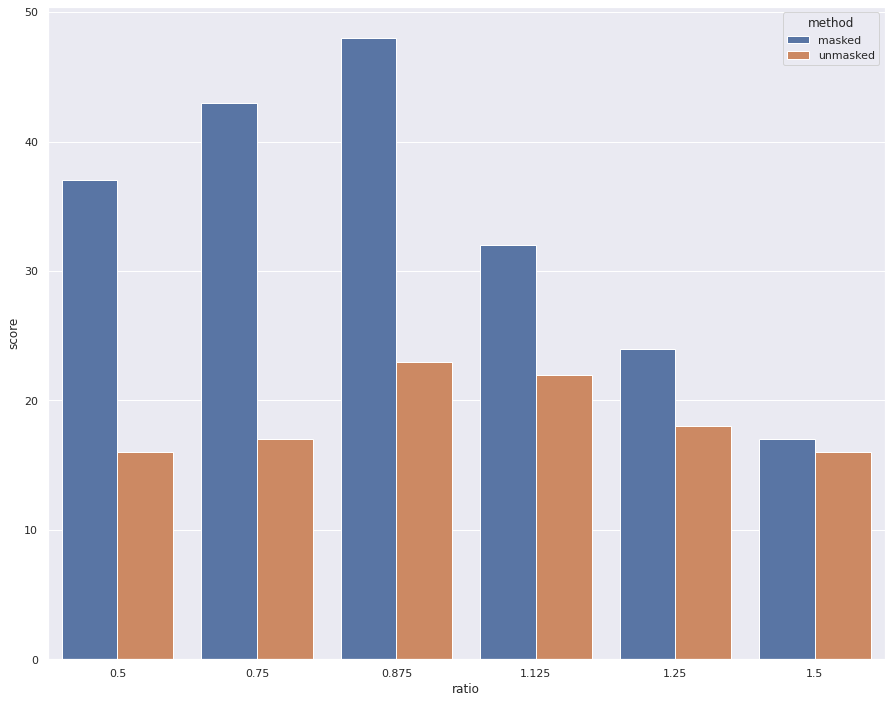

In [69]:
sns.barplot(data=df2[df2["score"] >= 1.].groupby(["ratio", "method"]).count().reset_index(), x="ratio", y="score", hue="method")

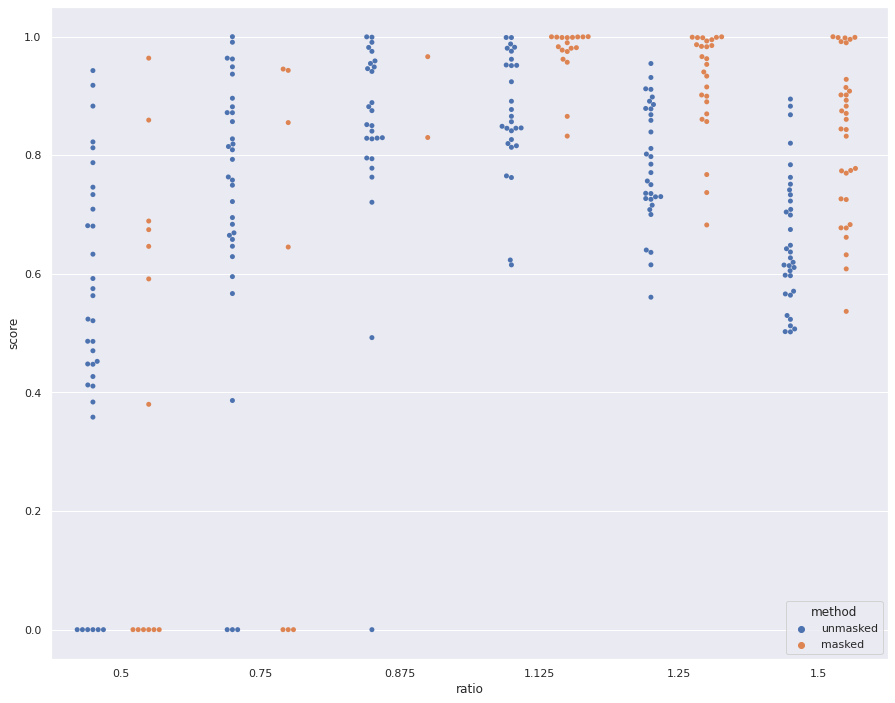

In [60]:
gfg = sns.swarmplot(data=df2[df2["score"] != 1.], x="ratio", y="score", hue="method", dodge=True)
# gfg.set(ylabel="wartość metryki")

In [9]:
stats

[[0.7514912712745581,
  0.7707317073170732,
  1.0,
  0.5362904269918952,
  0.7133928155537105,
  1.0,
  0.8967637348991917,
  0.7432096696094822,
  0.8493975903614458,
  0.802165725047081,
  1.0,
  0.6770327672234155,
  1.0,
  0.680723113816639,
  0.9217081850533808,
  0.7215930538211827,
  1.0,
  0.5542924553595368,
  0.7210191769015298,
  0.9173789173789174,
  0.7739932864903658,
  1.0,
  1.0,
  0.836462918144209,
  0.9134623486779798,
  1.0,
  1.0,
  1.0,
  0.8199261992619926,
  0.7615473956915497,
  0.9441955953714072,
  1.0,
  0.7436378024907326,
  0.6863260817804041,
  1.0,
  0.7739760115463097,
  0.8761537170666219,
  0.612116090527372,
  0.7819802140075763,
  0.6476678284948295,
  0.6610257933044387,
  1.0,
  0.9361128142244022,
  0.9007307453168496,
  1.0,
  0.8187197417966648,
  1.0,
  0.9615384615384616,
  0.746629627277522,
  0.803742636017096],
 [0.7384624107041615,
  0.92,
  1.0,
  0.4802105618736629,
  0.9736876390280919,
  1.0,
  0.9642387564167884,
  0.9347686801620868

[Text(59.125, 0.5, 'wartość metryki')]

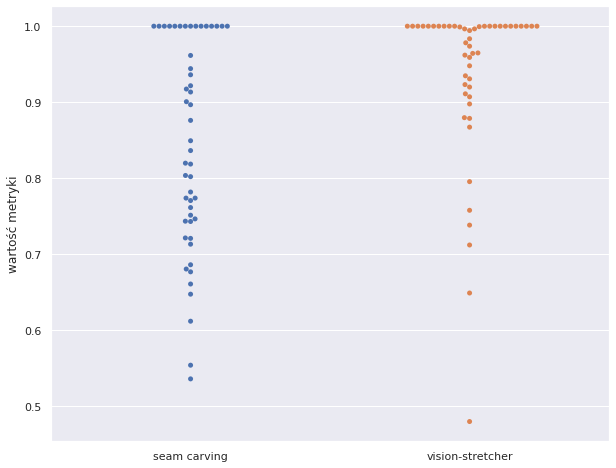

In [10]:
stats = [[0.7514912712745581,
  0.7707317073170732,
  1.0,
  0.5362904269918952,
  0.7133928155537105,
  1.0,
  0.8967637348991917,
  0.7432096696094822,
  0.8493975903614458,
  0.802165725047081,
  1.0,
  0.6770327672234155,
  1.0,
  0.680723113816639,
  0.9217081850533808,
  0.7215930538211827,
  1.0,
  0.5542924553595368,
  0.7210191769015298,
  0.9173789173789174,
  0.7739932864903658,
  1.0,
  1.0,
  0.836462918144209,
  0.9134623486779798,
  1.0,
  1.0,
  1.0,
  0.8199261992619926,
  0.7615473956915497,
  0.9441955953714072,
  1.0,
  0.7436378024907326,
  0.6863260817804041,
  1.0,
  0.7739760115463097,
  0.8761537170666219,
  0.612116090527372,
  0.7819802140075763,
  0.6476678284948295,
  0.6610257933044387,
  1.0,
  0.9361128142244022,
  0.9007307453168496,
  1.0,
  0.8187197417966648,
  1.0,
  0.9615384615384616,
  0.746629627277522,
  0.803742636017096],
 [0.7384624107041615,
  0.92,
  1.0,
  0.4802105618736629,
  0.9736876390280919,
  1.0,
  0.9642387564167884,
  0.9347686801620868,
  0.9942546114302994,
  0.9994042743316702,
  1.0,
  0.8672876410583714,
  1.0,
  0.712320773591197,
  0.9232142857142858,
  0.9071445263118638,
  1.0,
  0.9619336758524054,
  0.9964887137226801,
  0.9989827060020345,
  0.8977413579396777,
  1.0,
  1.0,
  0.8787853707266794,
  0.9834479165383286,
  1.0,
  1.0,
  1.0,
  0.947911227154047,
  0.8797369716596475,
  1.0,
  1.0,
  0.75793334396428,
  0.996441172582501,
  1.0,
  0.7956255943485939,
  1.0,
  0.6491921320688444,
  0.9307793413734121,
  0.9110664538498983,
  0.9648279393820611,
  1.0,
  1.0,
  1.0,
  1.0,
  0.9999404797333491,
  1.0,
  1.0,
  0.9589479169964277,
  0.978151735841052]]
data = {
  "seam carving": stats[0],
  "vision-stretcher": stats[1]
}
gfg = sns.swarmplot(data=data)
gfg.set(ylabel="wartość metryki")

3

In [3]:
with open("data/chunk4_dataset.pkl", "rb") as f:
    ds = pickle.load(f)

In [4]:
BATCH_SIZE = 128

train_len = int(len(ds) * 0.8)
val_len = len(ds) - train_len
train_ds, val_ds = random_split(ds, (train_len, val_len))
train_dl = DataLoader(train_ds, BATCH_SIZE, shuffle=True, pin_memory=True)
val_dl = DataLoader(val_ds, BATCH_SIZE, pin_memory=True)

In [6]:
model = OutpainterNet().to(device)

In [6]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
train(model, loss_fn, optimizer, train_dl, val_dl, device=device, print_metrics=True, epochs=50)
torch.save(model.state_dict(), "outpainter_net/state.pt")

  2%|▏         | 1/50 [01:42<1:23:43, 102.53s/it]

Epoch 0: train loss = 0.012, val loss = 0.011


  4%|▍         | 2/50 [03:21<1:20:17, 100.36s/it]

Epoch 1: train loss = 0.011, val loss = 0.011


  6%|▌         | 3/50 [05:00<1:18:19, 99.99s/it] 

Epoch 2: train loss = 0.011, val loss = 0.011


  8%|▊         | 4/50 [06:41<1:16:50, 100.23s/it]

Epoch 3: train loss = 0.011, val loss = 0.011


 10%|█         | 5/50 [08:22<1:15:25, 100.56s/it]

Epoch 4: train loss = 0.011, val loss = 0.011


 12%|█▏        | 6/50 [10:04<1:13:59, 100.89s/it]

Epoch 5: train loss = 0.011, val loss = 0.011


 14%|█▍        | 7/50 [11:44<1:12:16, 100.85s/it]

Epoch 6: train loss = 0.011, val loss = 0.011


 16%|█▌        | 8/50 [13:26<1:10:38, 100.91s/it]

Epoch 7: train loss = 0.011, val loss = 0.011


 18%|█▊        | 9/50 [15:06<1:08:53, 100.81s/it]

Epoch 8: train loss = 0.011, val loss = 0.011


 20%|██        | 10/50 [16:50<1:07:45, 101.63s/it]

Epoch 9: train loss = 0.011, val loss = 0.011


 22%|██▏       | 11/50 [18:30<1:05:50, 101.30s/it]

Epoch 10: train loss = 0.011, val loss = 0.011


 24%|██▍       | 12/50 [20:11<1:04:00, 101.07s/it]

Epoch 11: train loss = 0.011, val loss = 0.011


 26%|██▌       | 13/50 [21:51<1:02:14, 100.93s/it]

Epoch 12: train loss = 0.011, val loss = 0.011


 28%|██▊       | 14/50 [23:31<1:00:24, 100.69s/it]

Epoch 13: train loss = 0.011, val loss = 0.011


 30%|███       | 15/50 [25:12<58:43, 100.67s/it]  

Epoch 14: train loss = 0.011, val loss = 0.011


 32%|███▏      | 16/50 [26:52<56:54, 100.42s/it]

Epoch 15: train loss = 0.011, val loss = 0.011


 34%|███▍      | 17/50 [28:32<55:10, 100.33s/it]

Epoch 16: train loss = 0.011, val loss = 0.011


 36%|███▌      | 18/50 [30:13<53:35, 100.47s/it]

Epoch 17: train loss = 0.011, val loss = 0.011


 38%|███▊      | 19/50 [31:52<51:44, 100.15s/it]

Epoch 18: train loss = 0.011, val loss = 0.011


 40%|████      | 20/50 [33:32<50:00, 100.00s/it]

Epoch 19: train loss = 0.011, val loss = 0.011


 42%|████▏     | 21/50 [35:13<48:29, 100.34s/it]

Epoch 20: train loss = 0.011, val loss = 0.011


 44%|████▍     | 22/50 [36:53<46:45, 100.19s/it]

Epoch 21: train loss = 0.011, val loss = 0.010


 46%|████▌     | 23/50 [38:33<45:02, 100.10s/it]

Epoch 22: train loss = 0.011, val loss = 0.011


 48%|████▊     | 24/50 [40:13<43:22, 100.11s/it]

Epoch 23: train loss = 0.010, val loss = 0.010


 50%|█████     | 25/50 [41:53<41:45, 100.24s/it]

Epoch 24: train loss = 0.010, val loss = 0.010


 52%|█████▏    | 26/50 [43:33<39:58, 99.95s/it] 

Epoch 25: train loss = 0.010, val loss = 0.010


 54%|█████▍    | 27/50 [45:12<38:17, 99.91s/it]

Epoch 26: train loss = 0.010, val loss = 0.010


 56%|█████▌    | 28/50 [46:53<36:40, 100.02s/it]

Epoch 27: train loss = 0.010, val loss = 0.010


 58%|█████▊    | 29/50 [48:34<35:07, 100.33s/it]

Epoch 28: train loss = 0.010, val loss = 0.010


 60%|██████    | 30/50 [50:15<33:30, 100.51s/it]

Epoch 29: train loss = 0.010, val loss = 0.010


 62%|██████▏   | 31/50 [51:51<31:22, 99.10s/it] 

Epoch 30: train loss = 0.010, val loss = 0.010


 64%|██████▍   | 32/50 [53:27<29:27, 98.17s/it]

Epoch 31: train loss = 0.010, val loss = 0.010


 66%|██████▌   | 33/50 [55:04<27:46, 98.00s/it]

Epoch 32: train loss = 0.010, val loss = 0.011


 68%|██████▊   | 34/50 [56:41<26:04, 97.76s/it]

Epoch 33: train loss = 0.010, val loss = 0.010


 70%|███████   | 35/50 [58:21<24:34, 98.28s/it]

Epoch 34: train loss = 0.010, val loss = 0.010


 72%|███████▏  | 36/50 [1:00:01<23:05, 98.94s/it]

Epoch 35: train loss = 0.010, val loss = 0.010


 74%|███████▍  | 37/50 [1:01:41<21:30, 99.25s/it]

Epoch 36: train loss = 0.010, val loss = 0.010


 76%|███████▌  | 38/50 [1:03:22<19:55, 99.66s/it]

Epoch 37: train loss = 0.010, val loss = 0.010


 78%|███████▊  | 39/50 [1:05:01<18:13, 99.42s/it]

Epoch 38: train loss = 0.010, val loss = 0.010


 80%|████████  | 40/50 [1:06:40<16:34, 99.45s/it]

Epoch 39: train loss = 0.010, val loss = 0.010


 82%|████████▏ | 41/50 [1:08:20<14:54, 99.41s/it]

Epoch 40: train loss = 0.010, val loss = 0.010


 84%|████████▍ | 42/50 [1:09:59<13:14, 99.37s/it]

Epoch 41: train loss = 0.010, val loss = 0.010


 86%|████████▌ | 43/50 [1:11:38<11:35, 99.30s/it]

Epoch 42: train loss = 0.010, val loss = 0.010


 88%|████████▊ | 44/50 [1:13:17<09:55, 99.32s/it]

Epoch 43: train loss = 0.010, val loss = 0.010


 90%|█████████ | 45/50 [1:14:57<08:16, 99.31s/it]

Epoch 44: train loss = 0.010, val loss = 0.010


 92%|█████████▏| 46/50 [1:16:36<06:37, 99.26s/it]

Epoch 45: train loss = 0.010, val loss = 0.010


 94%|█████████▍| 47/50 [1:18:15<04:57, 99.16s/it]

Epoch 46: train loss = 0.010, val loss = 0.010


 96%|█████████▌| 48/50 [1:19:54<03:18, 99.21s/it]

Epoch 47: train loss = 0.010, val loss = 0.010


 98%|█████████▊| 49/50 [1:21:33<01:39, 99.18s/it]

Epoch 48: train loss = 0.010, val loss = 0.010


100%|██████████| 50/50 [1:23:11<00:00, 99.84s/it]

Epoch 49: train loss = 0.010, val loss = 0.010


[Text(0.5, 0, 'epoch')]

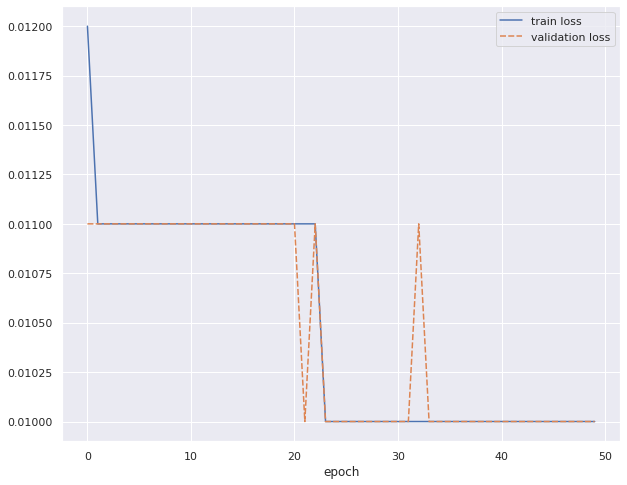

In [15]:
train_loss = [
    0.012,
    0.011,
    0.011,
    0.011,
    0.011,
    0.011,
    0.011,
    0.011,
    0.011,
    0.011,
    0.011,
    0.011,
    0.011,
    0.011,
    0.011,
    0.011,
    0.011,
    0.011,
    0.011,
    0.011,
    0.011,
    0.011,
    0.011,
    0.010,
    0.010,
    0.010,
    0.010,
    0.010,
    0.010,
    0.010,
    0.010,
    0.010,
    0.010,
    0.010,
    0.010,
    0.010,
    0.010,
    0.010,
    0.010,
    0.010,
    0.010,
    0.010,
    0.010,
    0.010,
    0.010,
    0.010,
    0.010,
    0.010,
    0.010,
    0.010,
]
val_loss = [
    0.011,
    0.011,
    0.011,
    0.011,
    0.011,
    0.011,
    0.011,
    0.011,
    0.011,
    0.011,
    0.011,
    0.011,
    0.011,
    0.011,
    0.011,
    0.011,
    0.011,
    0.011,
    0.011,
    0.011,
    0.011,
    0.010,
    0.011,
    0.010,
    0.010,
    0.010,
    0.010,
    0.010,
    0.010,
    0.010,
    0.010,
    0.010,
    0.011,
    0.010,
    0.010,
    0.010,
    0.010,
    0.010,
    0.010,
    0.010,
    0.010,
    0.010,
    0.010,
    0.010,
    0.010,
    0.010,
    0.010,
    0.010,
    0.010,
    0.010,
]
data = {
    "train loss": train_loss,
    "validation loss": val_loss
}
plot = sns.lineplot(data)
plot.set(xlabel="epoch")

[Text(0.5, 0, 'epoch')]

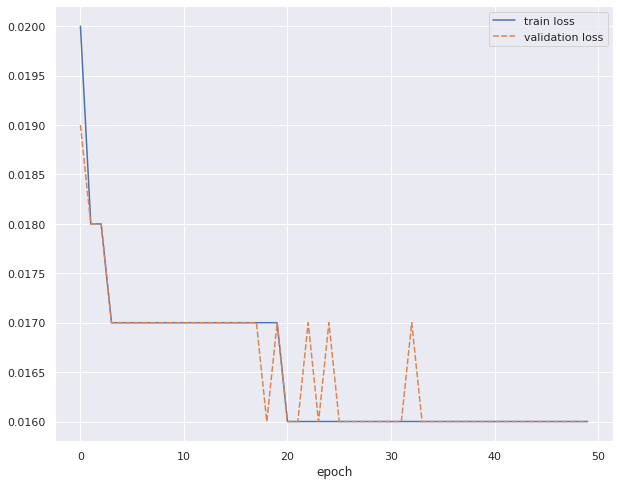

In [9]:
train_loss = [
    0.020,
    0.018,
    0.018,
    0.017,
    0.017,
    0.017,
    0.017,
    0.017,
    0.017,
    0.017,
    0.017,
    0.017,
    0.017,
    0.017,
    0.017,
    0.017,
    0.017,
    0.017,
    0.017,
    0.017,
    0.016,
    0.016,
    0.016,
    0.016,
    0.016,
    0.016,
    0.016,
    0.016,
    0.016,
    0.016,
    0.016,
    0.016,
    0.016,
    0.016,
    0.016,
    0.016,
    0.016,
    0.016,
    0.016,
    0.016,
    0.016,
    0.016,
    0.016,
    0.016,
    0.016,
    0.016,
    0.016,
    0.016,
    0.016,
    0.016,
]
val_loss = [
    0.019,
    0.018,
    0.018,
    0.017,
    0.017,
    0.017,
    0.017,
    0.017,
    0.017,
    0.017,
    0.017,
    0.017,
    0.017,
    0.017,
    0.017,
    0.017,
    0.017,
    0.017,
    0.016,
    0.017,
    0.016,
    0.016,
    0.017,
    0.016,
    0.017,
    0.016,
    0.016,
    0.016,
    0.016,
    0.016,
    0.016,
    0.016,
    0.017,
    0.016,
    0.016,
    0.016,
    0.016,
    0.016,
    0.016,
    0.016,
    0.016,
    0.016,
    0.016,
    0.016,
    0.016,
    0.016,
    0.016,
    0.016,
    0.016,
    0.016,
]
data = {
    "train loss": train_loss,
    "validation loss": val_loss
}
plot = sns.lineplot(data)
plot.set(xlabel="epoch")

[Text(0.5, 0, 'epoch')]

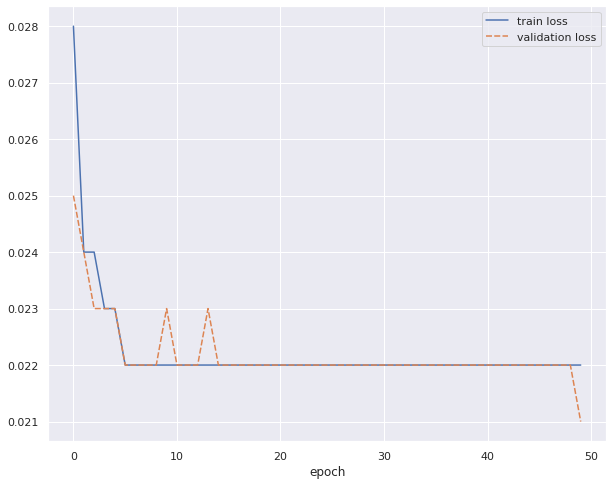

In [10]:
train_loss = [
    0.028,
    0.024,
    0.024,
    0.023,
    0.023,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
]
val_loss = [
    0.025,
    0.024,
    0.023,
    0.023,
    0.023,
    0.022,
    0.022,
    0.022,
    0.022,
    0.023,
    0.022,
    0.022,
    0.022,
    0.023,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.022,
    0.021,
]
data = {
    "train loss": train_loss,
    "validation loss": val_loss
}
plot = sns.lineplot(data)
plot.set(xlabel="epoch")

In [38]:

df

,pxl loss,adv loss,D loss
batch,,,
1,0.3992,2.1848,1.6137
2,0.4033,10.6560,9.5202
4,0.4003,2.4134,1.4148
8,0.2662,0.5178,0.2956
16,0.2054,0.7107,0.2878
32,0.1781,0.7793,0.1080
64,0.1808,0.9877,0.0655
128,0.1597,0.7204,0.0745
256,0.1580,0.9923,0.0411


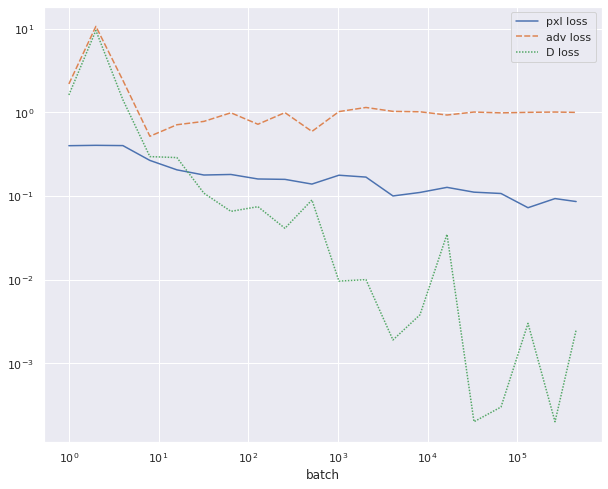

In [44]:
batches = [
    1,
    2,
    4,
    8,
    16,
    32,
    64,
    128,
    256,
    512,
    1024,
    2048,
    4096,
    8192,
    16384,
    32768,
    65536,
    131072,
    262144,
    450865
]
loss_pxl = [
    0.3992,
    0.4033,
    0.4003,
    0.2662,
    0.2054,
    0.1781,
    0.1808,
    0.1597,
    0.1580,
    0.1388,
    0.1771,
    0.1682,
    0.1001,
    0.1102,
    0.1268,
    0.1111,
    0.1071,
    0.0724,
    0.0931,
    0.0858
]
loss_adv = [
    2.1848,
    10.6560,
    2.4134,
    0.5178,
    0.7107,
    0.7793,
    0.9877,
    0.7204,
    0.9923,
    0.5913,
    1.0207,
    1.1435,
    1.0273,
    1.0157,
    0.9288,
    1.0082,
    0.9854,
    0.9995,
    1.0084,
    0.9984
]
loss_D = [
    1.6137,
    9.5202,
    1.4148,
    0.2956,
    0.2878,
    0.1080,
    0.0655,
    0.0745,
    0.0411,
    0.0896,
    0.0096,
    0.0100,
    0.0019,
    0.0038,
    0.0348,
    0.0002,
    0.0003,
    0.0030,
    0.0002,
    0.0025
]

data = {
    "batch": batches,
    "pxl loss": loss_pxl,
    "adv loss": loss_adv,
    "D loss": loss_D
}

df = pd.DataFrame(data)
df = df.set_index("batch")

sns.lineplot(df)
plt.yscale("log")
plt.xscale("log")

In [7]:
import glob
from typing import Any, Callable, Optional


def outpaint(model: nn.Module, batch: torch.Tensor, target_size: List[int]):
    if model.__class__ == OutpainterNet:
        return model.image_outpaint(batch, target_size)
    elif model.__class__ == outpainting.CEGenerator:
        outs = model(resize(batch, [128, 128]))
        return resize(outs, target_size)

@torch.no_grad()
def model_test(model: nn.Module, dl: DataLoader, input_size: List[int]):
    loss_fn = nn.MSELoss()
    total_loss = 0
    count = 0
    for batch in tqdm(dl):
        batch = batch.to(device)
        X = center_crop(batch, input_size)
        preds = outpaint(model, X, [256, 256])
        loss = loss_fn(preds, batch)
        total_loss += loss
        count += 1
    return total_loss.item() / count

def pil_loader(path: str) -> Image.Image:
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, "rb") as f:
        img = Image.open(f)
        return img.convert("RGB")

class BasicDataset(torchvision.datasets.VisionDataset):
    def __init__(self, root: str, transforms: Optional[Callable] = None, transform: Optional[Callable] = None, target_transform: Optional[Callable] = None) -> None:
        super().__init__(root, transforms, transform, target_transform)
        self.files = sorted(glob.glob("%s/**/*.jpg" % root, recursive=True))
    
    def __getitem__(self, index: int) -> Any:
        return self.transform(pil_loader(self.files[index]))
    
    def __len__(self) -> int:
        return len(self.files)

In [8]:
batch_size = 256

In [14]:
model.load_state_dict(torch.load("outpainter_net/state.pt"))
model.eval()

test_ds = BasicDataset("data/test_256/", transform=transforms)
test_dl = DataLoader(test_ds, batch_size, pin_memory=True)

In [10]:
model_test(model, test_dl, [171, 171])

100%|██████████| 1284/1284 [31:08<00:00,  1.46s/it]


0.05175549516053957

In [15]:
model_test(model, test_dl, [192, 192])

100%|██████████| 1284/1284 [16:25<00:00,  1.30it/s]


0.04353831935894452

In [11]:
model2 = outpainting.load_model('generator_final.pt').to(device)
model2.eval()

transforms2 = torchvision.transforms.Compose([
    torchvision.transforms.PILToTensor()
])
test_ds = BasicDataset("data/test_256/", transform=transforms)
test_dl = DataLoader(test_ds, batch_size, pin_memory=True)

In [12]:
model_test(model2, test_dl, [171, 171])

100%|██████████| 1284/1284 [19:38<00:00,  1.09it/s]


0.07265227605992017

In [13]:
model_test(model2, test_dl, [192, 192])

100%|██████████| 1284/1284 [15:46<00:00,  1.36it/s]


0.0657205017184914

4

In [ ]:
opn4 = OutpainterNet(chunk_size=4).to(device)
opn4.load_state_dict(torch.load("ne"))

In [40]:
samples = random.sample(range(len(test_ds)), 10)
samples = torch.stack([test_ds[i] for i in samples]).to(device)
samples1 = outpaint(model, samples, [384, 384])
samples1 = []
for i, sample in enumerate(samples):
    samples1.append(model.image_outpaint(sample.to(device).unsqueeze(0), (384, 384)).squeeze())
samples2 = []
for i, sample in enumerate(samples):
    samples2.append(outpainting.perform_outpaint(model2.cpu(), sample.transpose(0, 2).cpu().numpy())[1])

Input size: (256, 256, 3)
Output size: (192, 192, 3)
Blended size: (384, 384, 3)
Input size: (256, 256, 3)
Output size: (192, 192, 3)
Blended size: (384, 384, 3)
Input size: (256, 256, 3)
Output size: (192, 192, 3)
Blended size: (384, 384, 3)
Input size: (256, 256, 3)
Output size: (192, 192, 3)
Blended size: (384, 384, 3)
Input size: (256, 256, 3)
Output size: (192, 192, 3)
Blended size: (384, 384, 3)
Input size: (256, 256, 3)
Output size: (192, 192, 3)
Blended size: (384, 384, 3)
Input size: (256, 256, 3)
Output size: (192, 192, 3)
Blended size: (384, 384, 3)
Input size: (256, 256, 3)
Output size: (192, 192, 3)
Blended size: (384, 384, 3)
Input size: (256, 256, 3)
Output size: (192, 192, 3)
Blended size: (384, 384, 3)
Input size: (256, 256, 3)
Output size: (192, 192, 3)
Blended size: (384, 384, 3)


In [42]:
for i, sample in enumerate(samples1):
    back_to_pil(sample).save("data/experiments/3/mine_" + str(i) + ".png")
for i, sample in enumerate(samples2):
    Image.fromarray((sample * 256).astype(np.uint8)).rotate(-90).save("data/experiments/3/ref_" + str(i) + ".png")

In [23]:
pred = model.image_outpaint(test_ds[2].to(device).unsqueeze(0), (384, 384)).squeeze()

In [ ]:
pred = Image.fromarray(((test_ds[2]) * 256).astype(np.uint8))

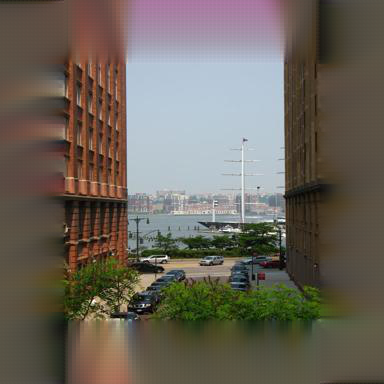

In [24]:
display(back_to_pil(pred))